In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import os.path
import skimage
import skimage.segmentation
import sklearn.preprocessing
import sklearn.model_selection
import math
import shutil
import pathlib
import glob
import shutil
import uuid
import random
import platform
import torch
import torchvision
import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
import pandas as pd
import networkx
import wfdb
import copy
import fleetfmt
import json
import tqdm
import dill
import pickle
import time
import matplotlib.pyplot as plt

import scipy.stats

import src.data
import src.reader

import sak
import sak.signal.wavelet
import sak.data
import sak.data.augmentation
import sak.visualization
import sak.visualization.signal
import sak.torch
import sak.torch.nn
import sak.torch.nn as nn
import sak.torch.train
import sak.torch.data
import sak.data.preprocessing
import sak.torch.models
import sak.torch.models.lego
import sak.torch.models.variational
import sak.torch.models.classification

from sak.signal import StandardHeader

def smooth(x: np.ndarray, window_size: int, conv_mode: str = 'same'):
    x = np.pad(np.copy(x),(window_size,window_size),'edge')
    window = np.hamming(window_size)/(window_size//2)
    x = np.convolve(x, window, mode=conv_mode)
    x = x[window_size:-window_size]
    return x

# From train_multi.py

In [3]:
bool_hpc    = False
model_name  = "TestSemiSupervisedLearning"
config_file = './configurations/MPLWNet5LevelsSelfAttention.json'
input_files = './pickle/'

##### 1. Load configuration file #####
with open(config_file, "r") as f:
    execution = json.load(f)

execution["root_directory"] = os.path.expanduser(execution["root_directory"])
execution["save_directory"] = os.path.expanduser(execution["save_directory"])

# NO ITERATOR FOR HPC, WASTE OF MEMORY
if bool_hpc:
    execution["iterator"] = "none"

##### 2. Load synthetic dataset #####
# 2.1. Load individual segments
P = sak.pickleload(os.path.join(input_files,"Psignal_new.pkl"))
PQ = sak.pickleload(os.path.join(input_files,"PQsignal_new.pkl"))
QRS = sak.pickleload(os.path.join(input_files,"QRSsignal_new.pkl"))
ST = sak.pickleload(os.path.join(input_files,"STsignal_new.pkl"))
T = sak.pickleload(os.path.join(input_files,"Tsignal_new.pkl"))
TP = sak.pickleload(os.path.join(input_files,"TPsignal_new.pkl"))

Pamplitudes = sak.pickleload(os.path.join(input_files,"Pamplitudes_new.pkl"))
PQamplitudes = sak.pickleload(os.path.join(input_files,"PQamplitudes_new.pkl"))
QRSamplitudes = sak.pickleload(os.path.join(input_files,"QRSamplitudes_new.pkl"))
STamplitudes = sak.pickleload(os.path.join(input_files,"STamplitudes_new.pkl"))
Tamplitudes = sak.pickleload(os.path.join(input_files,"Tamplitudes_new.pkl"))
TPamplitudes = sak.pickleload(os.path.join(input_files,"TPamplitudes_new.pkl"))

# 2.2. Get amplitude distribution
Pdistribution   = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(Pamplitudes.values()))))
PQdistribution  = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(PQamplitudes.values()))))
QRSdistribution = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.hstack((np.array(list(QRSamplitudes.values())), 2-np.array(list(QRSamplitudes.values()))))))
STdistribution  = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(STamplitudes.values()))))
Tdistribution   = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(Tamplitudes.values()))))
TPdistribution  = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(TPamplitudes.values()))))

# 2.3. Smooth all
window = 5
P   = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth(  P[k],window)),metric=sak.signal.abs_max) for k in   P}
PQ  = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth( PQ[k],window)),metric=sak.signal.abs_max) for k in  PQ}
QRS = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth(QRS[k],window)),metric=sak.signal.abs_max) for k in QRS}
ST  = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth( ST[k],window)),metric=sak.signal.abs_max) for k in  ST}
T   = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth(  T[k],window)),metric=sak.signal.abs_max) for k in   T}
TP  = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth( TP[k],window)),metric=sak.signal.abs_max) for k in  TP}


##### 3. Load QTDB #####
dataset             = pd.read_csv(os.path.join(input_files,'QTDB','Dataset.csv'), index_col=0)
dataset             = dataset.sort_index(axis=1)
labels              = np.asarray(list(dataset)) # In case no data augmentation is applied
description         = dataset.describe()
group               = {k: '_'.join(k.split('_')[:-1]) for k in dataset}
unique_ids          = list(set([k.split('_')[0] for k in dataset]))

# Load validity
validity            = sak.load_data(os.path.join(input_files,'QTDB','validity.csv'))

# Load fiducials
Pon_QTDB            = sak.load_data(os.path.join(input_files,'QTDB','PonNew.csv'))
Poff_QTDB           = sak.load_data(os.path.join(input_files,'QTDB','PoffNew.csv'))
QRSon_QTDB          = sak.load_data(os.path.join(input_files,'QTDB','QRSonNew.csv'))
QRSoff_QTDB         = sak.load_data(os.path.join(input_files,'QTDB','QRSoffNew.csv'))
Ton_QTDB            = sak.load_data(os.path.join(input_files,'QTDB','TonNew.csv'))
Toff_QTDB           = sak.load_data(os.path.join(input_files,'QTDB','ToffNew.csv'))

# Generate masks & signals
signal_QTDB = {}
segmentation_QTDB = {}
for k in tqdm.tqdm(QRSon_QTDB):
    # Check file exists and all that
    if k not in validity:
        print("Issue with file {}, continuing...".format(k))
        continue

    # Store signal
    signal = dataset[k][validity[k][0]:validity[k][1]].values
    signal = sak.signal.on_off_correction(signal)
    amplitude = np.median(sak.signal.moving_lambda(signal,200,sak.signal.abs_max))
    signal = signal/amplitude
    signal_QTDB[k] = signal[None,]

    # Generate boolean mask
    segmentation = np.zeros((3,dataset.shape[0]),dtype=bool)
    if k in Pon_QTDB:
        for on,off in zip(Pon_QTDB[k],Poff_QTDB[k]):
            segmentation[0,on:off] = True
    if k in QRSon_QTDB:
        for on,off in zip(QRSon_QTDB[k],QRSoff_QTDB[k]):
            segmentation[1,on:off] = True
    if k in Ton_QTDB:
        for on,off in zip(Ton_QTDB[k],Toff_QTDB[k]):
            segmentation[2,on:off] = True

    segmentation_QTDB[k] = segmentation[:,validity[k][0]:validity[k][1]]


##### 4. Generate random splits #####
# 4.1. Split into train and test
all_keys_synthetic = {}
for k in list(P) + list(PQ) + list(QRS) + list(ST) + list(T) + list(TP):
    uid = k.split("###")[0].split("_")[0].split("-")[0]
    if uid not in all_keys_synthetic:
        all_keys_synthetic[uid] = [k]
    else:
        all_keys_synthetic[uid].append(k)

all_keys_real = {}
for k in list(signal_QTDB) + list(segmentation_QTDB):
    uid = k.split("###")[0].split("_")[0].split("-")[0]
    if uid not in all_keys_real:
        all_keys_real[uid] = [k]
    else:
        all_keys_real[uid].append(k)

# 4.2. Get database and file
filenames = []
database = []
for k in all_keys_synthetic:
    filenames.append(k)
    if k.startswith("SOO"):
        database.append(0)
    elif k.startswith("sel"):
        database.append(1)
    else:
        database.append(2)
filenames = np.array(filenames)
database = np.array(database)

# Set random seed for the execution and perform train/test splitting
random.seed(execution["seed"])
np.random.seed(execution["seed"])
torch.random.manual_seed(execution["seed"])
splitter = sklearn.model_selection.StratifiedKFold(5).split(filenames,database)
splits = list(splitter)
indices_train = [s[0] for s in splits]
indices_valid = [s[1] for s in splits]

##### 5. Train folds #####
# 5.1. Save model-generating files
target_path = execution["save_directory"] # Store original output path for future usage
original_length = execution["dataset"]["length"]
if not os.path.isdir(os.path.join(target_path,model_name)):
    pathlib.Path(os.path.join(target_path,model_name)).mkdir(parents=True, exist_ok=True)
# shutil.copyfile("./train_multi.py",os.path.join(target_path,model_name,"train_multi.py"))
shutil.copyfile("./src/data.py",os.path.join(target_path,model_name,"data.py"))
shutil.copyfile("./src/metrics.py",os.path.join(target_path,model_name,"metrics.py"))
# shutil.copyfile("./sak/torch/nn/modules/loss.py",os.path.join(target_path,model_name,"loss.py"))
shutil.copyfile(config_file,os.path.join(target_path,model_name,os.path.split(config_file)[1]))

# 5.2. Save folds of valid files
all_folds_test = {"fold_{}".format(i+1): np.array(filenames)[ix_valid] for i,ix_valid in enumerate(indices_valid)}
sak.save_data(all_folds_test,os.path.join(target_path,model_name,"validation_files.csv"))

# 5.3. Iterate over folds
for i,(ix_train,ix_valid) in enumerate(zip(indices_train,indices_valid)):
    print("################# FOLD {} #################".format(i+1))
    # Synthetic keys
    train_keys_synthetic, valid_keys_synthetic = ([],[])
    for k in np.array(filenames)[ix_train]: 
        train_keys_synthetic += all_keys_synthetic[k]
    for k in np.array(filenames)[ix_valid]: 
        valid_keys_synthetic += all_keys_synthetic[k]

    # Real keys
    train_keys_real, valid_keys_real = ([],[])
    for k in np.array(filenames)[ix_train]: 
        if k in all_keys_real: train_keys_real += all_keys_real[k]
    for k in np.array(filenames)[ix_valid]: 
        if k in all_keys_real: valid_keys_real += all_keys_real[k]

    # Avoid repetitions
    train_keys_synthetic = list(set(train_keys_synthetic))
    valid_keys_synthetic = list(set(valid_keys_synthetic))
    train_keys_real = list(set(train_keys_real))
    valid_keys_real = list(set(valid_keys_real))

    # ~~~~~~~~~~~~~~~~~~~~ Refine synthetic set ~~~~~~~~~~~~~~~~~~~~
    # Divide train/valid segments
    Ptrain   = {k:   P[k] for k in   P if k in train_keys_synthetic}
    PQtrain  = {k:  PQ[k] for k in  PQ if k in train_keys_synthetic}
    QRStrain = {k: QRS[k] for k in QRS if k in train_keys_synthetic}
    STtrain  = {k:  ST[k] for k in  ST if k in train_keys_synthetic}
    Ttrain   = {k:   T[k] for k in   T if k in train_keys_synthetic}
    TPtrain  = {k:  TP[k] for k in  TP if k in train_keys_synthetic}

    Pvalid   = {k:   P[k] for k in   P if k in valid_keys_synthetic}
    PQvalid  = {k:  PQ[k] for k in  PQ if k in valid_keys_synthetic}
    QRSvalid = {k: QRS[k] for k in QRS if k in valid_keys_synthetic}
    STvalid  = {k:  ST[k] for k in  ST if k in valid_keys_synthetic}
    Tvalid   = {k:   T[k] for k in   T if k in valid_keys_synthetic}
    TPvalid  = {k:  TP[k] for k in  TP if k in valid_keys_synthetic}

    # ~~~~~~~~~~~~~~~~~~~~~~ Refine real set ~~~~~~~~~~~~~~~~~~~~~~~
    signal_QTDB_train       = {k:       signal_QTDB[k] for k in       signal_QTDB if k in train_keys_real}
    signal_QTDB_valid       = {k:       signal_QTDB[k] for k in       signal_QTDB if k in valid_keys_real}
    segmentation_QTDB_train = {k: segmentation_QTDB[k] for k in segmentation_QTDB if k in train_keys_real}
    segmentation_QTDB_valid = {k: segmentation_QTDB[k] for k in segmentation_QTDB if k in valid_keys_real}


    # Prepare folders
    execution["save_directory"] = os.path.join(target_path, model_name, "fold_{}".format(i+1))
    if not os.path.isdir(execution["save_directory"]):
        pathlib.Path(execution["save_directory"]).mkdir(parents=True, exist_ok=True)

    # Define synthetic datasets
    dataset_train_synthetic = src.data.Dataset(Ptrain, QRStrain, Ttrain, PQtrain, STtrain, TPtrain, 
                                               Pdistribution, QRSdistribution, Tdistribution, PQdistribution, 
                                               STdistribution, TPdistribution, **execution["dataset"])
    execution["dataset"]["length"] = execution["dataset"]["length"]//4 # On synthetic data, not so useful to do intensive validation
    dataset_valid_synthetic = src.data.Dataset(Pvalid, QRSvalid, Tvalid, PQvalid, STvalid, TPvalid, 
                                               Pdistribution, QRSdistribution, Tdistribution, PQdistribution, 
                                               STdistribution, TPdistribution, **execution["dataset"])
    execution["dataset"]["length"] = original_length # On synthetic data, not so useful to do intensive validation

    # Define real datasets
    dataset_train_real = src.data.DatasetQTDB(signal_QTDB_train,segmentation_QTDB_train,execution["dataset"]["N"],128)
    dataset_valid_real = src.data.DatasetQTDB(signal_QTDB_valid,segmentation_QTDB_valid,execution["dataset"]["N"],128)

    # Define merging dataset
    dataset_train = sak.torch.data.UniformMultiDataset((dataset_train_synthetic,dataset_train_real),[10,1],[1,10],return_weights=True)
    sampler_train = sak.torch.data.UniformMultiSampler(dataset_train)
    dataset_valid = sak.torch.data.UniformMultiDataset((dataset_valid_synthetic,dataset_valid_real),[10,1],[1,10],return_weights=True)
    sampler_valid = sak.torch.data.UniformMultiSampler(dataset_valid)

    # Create dataloaders
    loader_train = torch.utils.data.DataLoader(dataset_train, sampler=sampler_train, **execution["loader"])
    loader_valid = torch.utils.data.DataLoader(dataset_valid, sampler=sampler_valid, **execution["loader"])

    # Define model
    model_teacher = sak.from_dict(execution["model"]).float().cuda()
    model_student = sak.from_dict(execution["model"]).float().cuda()

    # Train model
    state = {
        "epoch"             : 0,
        "device"            : torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        "optimizer_teacher" : sak.class_selector(execution["optimizer"]["class"])(model_teacher.parameters(), **execution["optimizer"]["arguments"]),
        "optimizer_student" : sak.class_selector(execution["optimizer"]["class"])(model_student.parameters(), **execution["optimizer"]["arguments"]),
        "root_dir"          : "./"
    }
    if "scheduler" in execution:
        dict_scheduler = copy.deepcopy(execution["scheduler"])
        dict_scheduler["arguments"]["optimizer"] = state["optimizer_teacher"]
        state["scheduler_teacher"] = sak.from_dict(dict_scheduler)
        dict_scheduler = copy.deepcopy(execution["scheduler"])
        dict_scheduler["arguments"]["optimizer"] = state["optimizer_student"]
        state["scheduler_student"] = sak.from_dict(dict_scheduler)
    
    if "lr_scheduler" in execution:
        dict_lr_scheduler = copy.deepcopy(execution["lr_scheduler"])
        dict_lr_scheduler["arguments"]["optimizer"] = state["optimizer_teacher"]
        state["lr_scheduler_teacher"] = sak.from_dict(dict_lr_scheduler)
        dict_lr_scheduler = copy.deepcopy(execution["lr_scheduler"])
        dict_lr_scheduler["arguments"]["optimizer"] = state["optimizer_student"]
        state["lr_scheduler_student"] = sak.from_dict(dict_lr_scheduler)

    break

100%|██████████| 206/206 [00:00<00:00, 2485.57it/s]


Issue with file sel35_0, continuing...
Issue with file sel35_1, continuing...
################# FOLD 1 #################


/home/guille/GitHub/DelineatorSwitchAndCompose/Notebooks/sak/torch/nn/modules/composers.py:58: UserWarning: Nodes set() are leafs but not marked as outputs. Check the provided config file
  warnings.warn("Nodes {} are leafs but not marked as outputs. Check the provided config file".format(terminal_nodes-terminal_outputs))


In [6]:
##### 1. Load configuration file #####
with open(config_file, "r") as f:
    execution = json.load(f)

execution["root_directory"] = os.path.expanduser(execution["root_directory"])
execution["save_directory"] = os.path.expanduser(execution["save_directory"])

In [7]:
import src.train

dataset_mpl = sak.from_dict(execution["dataset_unsupervised"])
loader_mpl  = torch.utils.data.DataLoader(dataset_mpl, **execution["loader_unsupervised"])
generator   = src.train.get_batch_ssl(loader_train,loader_mpl)

len(loader_train),len(loader_mpl)

(9078, 15887)

In [8]:
model_teacher = sak.from_dict(execution["model"]).float()
model_student = sak.from_dict(execution["model"]).float()

inputs_teacher  = {"x": torch.rand(1,1,2048).float(), "y": torch.ge(torch.rand(1,3,2048),0.5).float()}
outputs_teacher = model_teacher.forward(inputs_teacher)
inputs_student  = {"x": torch.rand(1,1,2048).float(), "y": torch.ge(torch.rand(1,3,2048),0.5).float()}
outputs_student = model_student.forward(inputs_student)


In [9]:
config                 = copy.deepcopy(execution)
dataloader_labeled     = loader_train
dataloader_unlabeled   = loader_mpl
criterion              = sak.from_dict(execution['loss'])
criterion_crossentropy = sak.from_dict(execution['loss_crossentropy'])
# criterion_UDA        = sak.from_dict(execution['loss_UDA'])

In [11]:
##### 1. Load configuration file #####
with open(config_file, "r") as f:
    execution = json.load(f)

execution["root_directory"] = os.path.expanduser(execution["root_directory"])
execution["save_directory"] = os.path.expanduser(execution["save_directory"])
config = copy.deepcopy(execution)






# Log progress
max_length = max(len(dataloader_labeled),len(dataloader_unlabeled))
batch_loss = np.zeros((max_length,2),dtype='float16')
generator  = src.train.get_batch_ssl(dataloader_labeled,dataloader_unlabeled)
state["moving_dot_product"] = state.get("moving_dot_product",0)

# Create transforms
if ('data_pre' in config):
    data_pre     = sak.from_dict(config["data_pre"])
if ('augmentation' in config) and model_student.training:
    augmentation = sak.from_dict(config["augmentation"])
if ('data_post' in config):
    data_post    = sak.from_dict(config["data_post"])

# Select iterator decorator
train_type = 'Train' if model_student.training else 'Valid'
iterator = sak.get_tqdm(generator, config.get('iterator',''), 
                        desc="({}) Epoch {:>3d}/{:>3d}, Loss {:0.3f}".format(train_type, 
                                                                             state['epoch']+1, 
                                                                             config['epochs'], np.inf))


for i,(inputs_sup,inputs_unsup) in enumerate(iterator):
    # Apply data transforms
    if ('data_pre' in config):
        data_pre(inputs=inputs_sup)
        data_pre(inputs=inputs_unsup)
    if ('augmentation' in config) and model_student.training:
        augmentation(inputs=inputs_sup)
        augmentation(inputs=inputs_unsup)
    if ('data_post' in config):
        data_post(inputs=inputs_sup)
        data_post(inputs=inputs_unsup)

    # UDA
    inputs_aug = copy.deepcopy(inputs_unsup)
    if ('augmentation' in config) and model_student.training:
        for _ in range(random.randint(0,config["UDA"].get("max_N",5)-2)):
            augmentation(inputs=inputs_aug)
            
    # Map models to device
    model_teacher = model_teacher.to(state['device'], non_blocking=True)
    model_student = model_student.to(state['device'], non_blocking=True)
    
    # Set gradients to zero
    if model_teacher.training: state['optimizer_teacher'].zero_grad()
    if model_student.training: state['optimizer_student'].zero_grad()
    
    # Predict supervised data
    inputs_sup            = {k: v.to(state["device"], non_blocking=True) for k,v in inputs_sup.items()}
    outputs_sup_teacher   = {k: v.cpu() for k,v in model_teacher(inputs_sup).items()}
    outputs_sup_student   = {k: v.cpu() for k,v in model_student(inputs_sup).items()}
    inputs_sup            = {k: v.cpu() for k,v in inputs_sup.items()}
    
    # Predict unsupervised data
    inputs_unsup          = {k: v.to(state["device"], non_blocking=True) for k,v in inputs_unsup.items()}
    outputs_unsup_teacher = {k: v.cpu() for k,v in model_teacher(inputs_unsup).items()}
    inputs_unsup          = {k: v.cpu() for k,v in inputs_unsup.items()}

    # Predict augmented data
    inputs_aug            = {k: v.to(state["device"], non_blocking=True) for k,v in inputs_aug.items()}
    outputs_aug_teacher   = {k: v.cpu() for k,v in model_teacher(inputs_aug).items()}
    outputs_aug_student   = {k: v.cpu() for k,v in model_student(inputs_aug).items()}
    inputs_aug            = {k: v.cpu() for k,v in inputs_aug.items()}
    
    # Supervised loss UDA
    uda_sup_loss          = criterion(inputs=inputs_sup,outputs=outputs_sup_teacher,state=state)
    
    # Temperature on unsupervised for UDA
    outputs_unsup_teacher_temp = {k: v.clone().detach() for k,v in outputs_unsup_teacher.items()}
    outputs_unsup_teacher_temp["logits"] = outputs_unsup_teacher_temp["logits"]/config["UDA"].get("temperature",0.7)
    outputs_unsup_teacher_temp["probas"] = torch.sigmoid(outputs_unsup_teacher_temp["logits"])
    
    # Mask outputs for unsupervised loss
    largest_probs,_       = torch.max(outputs_unsup_teacher_temp["probas"].detach().flatten(start_dim=1),dim=-1)
    mask_elements         = torch.ge(largest_probs,config["UDA"].get("mask_threshold",0.6)).float() # GOOD ONE
    for _ in range(outputs_unsup_teacher_temp["probas"].ndim-1):
        mask_elements     = mask_elements.unsqueeze(-1)
    outputs_aug_teacher_mask   = {k: v.clone()*mask_elements for k,v in outputs_aug_teacher.items()}
    outputs_unsup_teacher_temp = {k: v.clone()*mask_elements for k,v in outputs_unsup_teacher_temp.items()}
    outputs_unsup_teacher_temp["y"] = outputs_unsup_teacher_temp["probas"]
        
    # Unsupervised loss UDA
    uda_unsup_loss        = criterion(inputs=outputs_unsup_teacher_temp,outputs=outputs_aug_teacher_mask,state=state)

    # Total loss UDA
    step                  = max_length*state["epoch"] + i
    uda_weight_decay      = config["UDA"].get("weight_decay",0) # compute weight decay
    uda_weight            = config["UDA"].get("weight",10)*min(step/config["UDA"].get("steps",1),1)
    uda_total_loss        = (uda_weight*uda_unsup_loss) + uda_sup_loss + uda_weight_decay
    

    #########################
    # Loss on UDA labels, "for backprop" and "For Taylor"
    outputs_aug_teacher_detached = {k: v.clone().detach() for k,v in outputs_aug_teacher.items()}
    outputs_aug_teacher_detached["y"] = outputs_aug_teacher_detached["probas"]
    student_loss          = criterion(inputs=outputs_aug_teacher_detached, outputs=outputs_aug_student,state=state)
    student_loss_cce_prev = criterion(inputs=inputs_sup, outputs=outputs_sup_student,state=state)

    # Optimize network's weights
    # Break early
    if torch.isnan(student_loss):
        raise ValueError("Nan loss value encountered. Stopping...")
    if model_student.training:
        student_loss.backward()
        torch.nn.utils.clip_grad_norm_(model_student.parameters(),config["UDA"].get("grad_clip",5.0))
        state["optimizer_student"].step()
        if "lr_scheduler_student" in state:
            state["lr_scheduler_student"].step()

    # Apply Exponential Moving Average of student model
    if config["UDA"].get("ema",0) > 0: 
        state["ema_model"].update_parameters(model_student)

    # 2nd call to student: get logits & cross-entropy
    # Predict supervised data
    inputs_sup               = {k: v.to(state["device"], non_blocking=True) for k,v in inputs_sup.items()}
    outputs_sup_student_next = {k: v.cpu() for k,v in model_student(inputs_sup).items()}
    inputs_sup               = {k: v.cpu() for k,v in inputs_sup.items()}
    
    # Get supervised loss
    student_loss_cce_next    = criterion(inputs=inputs_sup, outputs=outputs_sup_student_next,state=state)

    # Get dot product, moving average of dot product & correct dot product with moving average
    dot_product               = (student_loss_cce_next - student_loss_cce_prev).detach()
    moving_dot_product        = state["moving_dot_product"] + 0.01*(dot_product-state["moving_dot_product"])
    dot_product              -= state["moving_dot_product"]

    # Final teacher loss
    crossentropy_loss         = criterion_crossentropy(inputs=outputs_aug_teacher_detached,outputs=outputs_aug_teacher,state=state)
    teacher_loss              = uda_total_loss + dot_product*crossentropy_loss

    # Optimize teacher
    if torch.isnan(teacher_loss):
        raise ValueError("Nan loss value encountered. Stopping...")
    if model_teacher.training:
        teacher_loss.backward()
        torch.nn.utils.clip_grad_norm_(model_teacher.parameters(),config["UDA"].get("grad_clip",5.0))
        state["optimizer_teacher"].step()
        if "lr_scheduler_teacher" in state:
            state["lr_scheduler_teacher"].step()
    
    # Retrieve for printing purposes
    print_loss = (student_loss.item(),teacher_loss.item())

    # Accumulate losses
    batch_loss[i] = print_loss
    
    # Change iterator description
    if isinstance(iterator,tqdm.tqdm):
        if i == max_length-1: batch_print = np.mean(batch_loss,axis=0)
        else:                    batch_print = print_loss
        iterator.set_description("({}) Epoch {:>3d}/{:>3d}, Loss {:10.3f}, {:10.3f}".format(train_type, state['epoch']+1, config['epochs'], batch_print[0], batch_print[1]))
        iterator.refresh()


(Train) Epoch   1/100, Loss inf: 0it [00:00, ?it/s]/home/guille/VirtEnv/DeepLearning/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
(Train) Epoch   1/100, Loss      3.000,      3.276: : 148it [00:35,  4.13it/s]


KeyboardInterrupt: 

In [ ]:
np.random.beta()

In [68]:
tmp_x = inputs_sup["x"].clone()
tmp_y = inputs_sup["y"].clone()

In [106]:
list(tmp_x.shape) + [1]

[8, 1, 2048, 1]

In [110]:
tmp_x.unsqueeze(-1).shape

torch.Size([8, 1, 2048, 1])

In [72]:
bs = tmp_x.shape[0]

In [96]:
bbb = np.array([(0,1),(1,2),(2,3),(3,4),(4,5),(5,6),(6,7),])

In [101]:
bbb[3]

array([3, 4])

In [77]:
tmp_a = np.random.permutation(np.arange(bs))

In [87]:
import itertools

In [188]:
class CutMix:
    """Apply adapted CutMix (https://github.com/clovaai/CutMix-PyTorch/blob/master/train.py)
    """
    def __init__(self, beta: float):
        self.beta = beta
        
    def __call__(self, *args: List[torch.Tensor]) -> List[torch.Tensor]:
        # Check inputs
        for i,elem_i in enumerate(args):
            assert isinstance(elem_i, torch.Tensor), "Non-tensor inputs provided"
            for j,elem_j in enumerate(args):
                if i == j: continue
                assert elem_i.shape[2:] == elem_j.shape[2:], "The shapes of the input tensors do not coincide"
        bs   = np.unique([v.shape[0] for v in args])
        ndim = np.unique([v.ndim     for v in args])
        assert   bs.size == 1, "The batch size is inconsistent"
        assert ndim.size == 1, "Number of dimensions are inconsistent"
        bs,ndim = bs[0],ndim[0]

        # If single batch size, nothing can be done
        if bs == 1:
            return args
        
        # Get beta value
        lmbda = np.random.beta(self.beta,self.beta)
        
        # Match source and destination
        match = np.random.permutation(np.arange(bs))
        zip_match = zip(match[:match.size//2],match[match.size//2:])

        # Iterate over matches
        outputs = []
        for i,elem in enumerate(args):
            outputs.append(elem.clone())
        for src,dst in zip_match:
            # Generate bounding box per match
            bbox = self.__rand_bbox(args[0].shape, lmbda)

            # Apply bounding box to all input tensors
            # TO DO - IMPROVE
            for i,elem in enumerate(args):
                if   len(bbox) == 1:
                    ((x1,y1),) = bbox
                    tmp_src = elem[src,:,x1:y1]
                    tmp_dst = elem[dst,:,x1:y1]
                    outputs[i][dst,:,x1:y1] = tmp_src
                    outputs[i][src,:,x1:y1] = tmp_dst
                elif len(bbox) == 2:
                    ((x1,y1),(x2,y2),) = bbox
                    tmp_src = elem[src,:,x1:y1,x2:y2]
                    tmp_dst = elem[dst,:,x1:y1,x2:y2]
                    outputs[i][dst,:,x1:y1,x2:y2] = tmp_src
                    outputs[i][src,:,x1:y1,x2:y2] = tmp_dst
                elif len(bbox) == 3:
                    ((x1,y1),(x2,y2),(x3,y3),) = bbox
                    tmp_src = elem[src,:,x1:y1,x2:y2,x3:y3]
                    tmp_dst = elem[dst,:,x1:y1,x2:y2,x3:y3]
                    outputs[i][dst,:,x1:y1,x2:y2,x3:y3] = tmp_src
                    outputs[i][src,:,x1:y1,x2:y2,x3:y3] = tmp_dst
                elif len(bbox) == 4:
                    ((x1,y1),(x2,y2),(x3,y3),(x4,y4)) = bbox
                    tmp_src = elem[src,:,x1:y1,x2:y2,x3:y3,x4:y4]
                    tmp_dst = elem[dst,:,x1:y1,x2:y2,x3:y3,x4:y4]
                    outputs[i][dst,:,x1:y1,x2:y2,x3:y3,x4:y4] = tmp_src
                    outputs[i][src,:,x1:y1,x2:y2,x3:y3,x4:y4] = tmp_dst
                else: 
                    raise NotImplementedError("Not implemented for tensors of dimension larger than 4")

        return outputs

    def __rand_bbox(self, shape: List[int], lmbda: float) -> np.ndarray:
        bbox = []
        cut_ratio = np.sqrt(1. - lmbda)
        for size in shape[2:]:
            # Define cut size
            cut_size = int(size*cut_ratio)

            # Randomly define the location
            loc = np.random.randint(size)

            bbox.append((np.clip(loc-cut_size//2,0,size),np.clip(loc+cut_size//2,0,size)))

        return np.array(bbox)



In [189]:
for batch in loader_train:
    break

In [190]:
a_x,a_y = batch["x"],batch["y"]
cm = CutMix(0.5)
b_x,b_y = cm(a_x,a_y)

In [180]:
bbox = np.array([(0,1),(2,3),(4,5),(6,7),])

In [181]:
((x1,y1),(x2,y2),(x3,y3),(x4,y4)) = bbox

In [191]:
class EMA(torch.nn.Module):
    """Implementation from https://github.com/kekmodel/MPL-pytorch 
       -> models.py (c116572e78d64492e2f000a14e480e1ab0d3c691)"""
    def __init__(self, model, decay=0.9999, device=None):
        super().__init__()
        self.module = copy.deepcopy(model)
        self.module.eval()
        self.decay = decay
        self.device = device
        if self.device is not None:
            self.module.to(device=device)

    def forward(self, input):
        return self.module(input)

    def _update(self, model, update_fn):
        with torch.no_grad():
            for ema_v, model_v in zip(self.module.parameters(), model.parameters()):
                if self.device is not None:
                    model_v = model_v.to(device=self.device)
                ema_v.copy_(update_fn(ema_v, model_v))
            for ema_v, model_v in zip(self.module.buffers(), model.buffers()):
                if self.device is not None:
                    model_v = model_v.to(device=self.device)
                ema_v.copy_(model_v)

    def update_parameters(self, model):
        self._update(model, update_fn=lambda e, m: self.decay * e + (1. - self.decay) * m)

    def state_dict(self):
        return self.module.state_dict()

    def load_state_dict(self, state_dict):
        self.module.load_state_dict(state_dict)




In [192]:
ema = EMA(model_student)

In [202]:
ema.update_parameters(model_student)

In [204]:
len(dataset_mpl)

508354

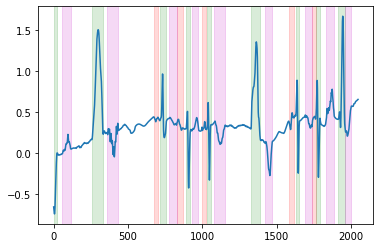

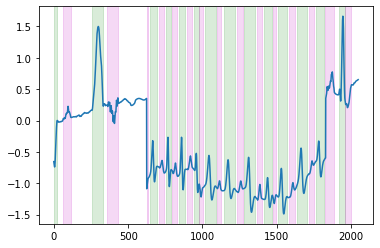

In [172]:
colors = ["r","g","m"]
i = 4
plt.figure(); plt.plot(a_x[i,0])
for j in range(3): [plt.axvspan(on,off,color=colors[j],alpha=0.15) for on,off in zip(*sak.signal.get_mask_boundary(a_y[i,j].numpy() > 0.95))]
plt.figure(); plt.plot(b_x[i,0])
for j in range(3): [plt.axvspan(on,off,color=colors[j],alpha=0.15) for on,off in zip(*sak.signal.get_mask_boundary(b_y[i,j].numpy() > 0.95))]


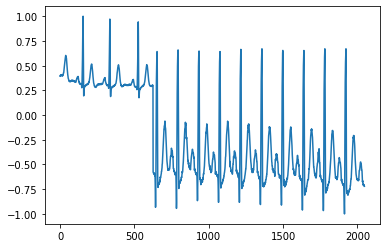

In [24]:
for _ in tqdm.tqdm(loader_train):
    pass

  7%|▋         | 678/9078 [00:12<02:31, 55.31it/s]


KeyboardInterrupt: 

Exception in thread Thread-13:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/guille/VirtEnv/DeepLearning/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 28, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 116, in get
    return _ForkingPickler.loads(res)
  File "/home/guille/VirtEnv/DeepLearning/lib/python3.8/site-packages/torch/multiprocessing/reductions.py", line 289, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.8/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.8/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.cur

In [25]:
for _ in tqdm.tqdm(loader_mpl):
    pass

  2%|▏         | 334/15887 [00:08<06:54, 37.50it/s]


KeyboardInterrupt: 

In [84]:
"""
Minimum do_epoch example
1. Select device to send tensors
2. Initialize loss function
3. Predict + optimize batch
4. Save loss per batch (useful given size of dataset)
"""

# Record progress
max_length = max(len(dataloader_labeled),len(dataloader_unlabeled))
batch_loss = np.zeros((max_length,),dtype='float16')
generator  = src.train.get_batch_ssl(dataloader_labeled,dataloader_unlabeled)

# Create transforms
if ('data_pre' in config):
    data_pre     = sak.from_dict(config["data_pre"])
if ('augmentation' in config) and model_student.training:
    augmentation = sak.from_dict(config["augmentation"])
if ('data_post' in config):
    data_post    = sak.from_dict(config["data_post"])

# Select iterator decorator
train_type = 'Train' if model_student.training else 'Valid'
iterator = sak.get_tqdm(generator, config.get('iterator',''), 
                        desc="({}) Epoch {:>3d}/{:>3d}, Loss {:0.3f}".format(train_type, 
                                                                             state['epoch']+1, 
                                                                             config['epochs'], np.inf))

# Iterate over all data in train/validation/test dataloader:
print_loss = np.inf
for i,inputs in enumerate(iterator):
    agkhkjasghkjas
    # Apply data transforms
    if ('data_pre' in config):
        data_pre(inputs=inputs)
    if ('augmentation' in config) and model_student.training:
        augmentation(inputs=inputs)
    if ('data_post' in config):
        data_post(inputs=inputs)
        
    hakjghakjghj

    # Map all inputs to device
    for k in inputs:
        inputs[k] = inputs[k].to(state['device'], non_blocking=True)

    # Set gradient to zero
    if model.training: 
        state['optimizer'].zero_grad()

    # Predict input data
    outputs = model(inputs)

    # Calculate loss
    loss = criterion(inputs=inputs,outputs=outputs,state=state)

    # Break early
    if torch.isnan(loss):
        raise ValueError("Nan loss value encountered. Stopping...")

    # Retrieve for printing purposes
    print_loss = loss.item()

    # Optimize network's weights
    if model.training:
        loss.backward()
        state['optimizer'].step()

    # Accumulate losses
    batch_loss[i] = print_loss

    # Change iterator description
    if isinstance(iterator,tqdm.tqdm):
        if i == len(iterator)-1: batch_print = np.mean(batch_loss)
        else:                    batch_print = print_loss
        iterator.set_description("({}) Epoch {:>3d}/{:>3d}, Loss {:10.3f}".format(train_type, state['epoch']+1, config['epochs'], batch_print))
        iterator.refresh()


(Train) Epoch   1/100, Loss inf: 0it [00:01, ?it/s]


NameError: name 'agkhkjasghkjas' is not defined

In [60]:
generator

<generator object get_batch_ssl at 0x7fbcd2aa35f0>

In [ ]:
def do_epoch_ssl(model: torch.nn.Module, state: dict, config: dict, 
                 dataloader_labeled:   torch.utils.data.DataLoader, 
                 dataloader_unlabeled: torch.utils.data.DataLoader, 
                 criterion: Callable, 
                 criterion_crossentropy: Callable) -> list:
    """
    Minimum do_epoch example
    1. Select device to send tensors
    2. Initialize loss function
    3. Predict + optimize batch
    4. Save loss per batch (useful given size of dataset)
    """
    
    # Record progress
    max_length = max(len(dataloader_labeled),len(dataloader_unlabeled))
    batch_loss = np.zeros((max_length,),dtype='float16')

    # Create transforms
    if ('data_pre' in config):
        data_pre     = sak.from_dict(config["data_pre"])
    if ('augmentation' in config) and model.training:
        augmentation = sak.from_dict(config["augmentation"])
    if ('data_post' in config):
        data_post    = sak.from_dict(config["data_post"])

    # Select iterator decorator
    train_type = 'Train' if model.training else 'Valid'
    iterator = sak.get_tqdm(dataloader, config.get('iterator',''), 
                            desc="({}) Epoch {:>3d}/{:>3d}, Loss {:0.3f}".format(train_type, 
                                                                                 state['epoch']+1, 
                                                                                 config['epochs'], np.inf))

    # Iterate over all data in train/validation/test dataloader:
    print_loss = np.inf
    for i, inputs in enumerate(iterator):
        # Apply data transforms
        if ('data_pre' in config):
            data_pre(inputs=inputs)
        if ('augmentation' in config) and model.training:
            augmentation(inputs=inputs)
        if ('data_post' in config):
            data_post(inputs=inputs)

        # Map all inputs to device
        for k in inputs:
            inputs[k] = inputs[k].to(state['device'], non_blocking=True)

        # Set gradient to zero
        if model.training: 
            state['optimizer'].zero_grad()

        # Predict input data
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(inputs=inputs,outputs=outputs,state=state)

        # Break early
        if torch.isnan(loss):
            raise ValueError("Nan loss value encountered. Stopping...")

        # Retrieve for printing purposes
        print_loss = loss.item()
        
        # Optimize network's weights
        if model.training:
            loss.backward()
            state['optimizer'].step()

        # Accumulate losses
        batch_loss[i] = print_loss

        # Change iterator description
        if isinstance(iterator,tqdm.tqdm):
            if i == len(iterator)-1: batch_print = np.mean(batch_loss)
            else:                    batch_print = print_loss
            iterator.set_description("({}) Epoch {:>3d}/{:>3d}, Loss {:10.3f}".format(train_type, state['epoch']+1, config['epochs'], batch_print))
            iterator.refresh()

    return batch_loss


def train_model_ssl(model, state: dict, config: dict, loader: torch.utils.data.DataLoader):
    # Send model to device
    model = model.to(state['device'])

    # Instantiate criterion
    criterion = sak.from_dict(config['loss'])
    
    # Initialize best loss for early stopping
    if 'best_loss' not in state:
        state['best_loss'] = np.inf

    # Get savedir string
    if "savedir" in config:          str_savedir = 'savedir'
    elif "save_directory" in config: str_savedir = 'save_directory'
    else: raise ValueError("Configuration file should include either the 'savedir' or 'save_directory' fields [case-sensitive]")

    # Iterate over epochs
    for epoch in range(state['epoch'], config['epochs']):
        try:
            # Store current epoch
            state['epoch'] = epoch
            
            # Train model
            loss_train = do_epoch(model.train(), state, config, loader, criterion)
            state['loss_train'] = np.mean(loss_train)

            # Save model/state info
            model = model.cpu().eval()
            torch.save(model,              os.path.join(config[str_savedir],'checkpoint.model'),      pickle_module=dill)
            torch.save(model.state_dict(), os.path.join(config[str_savedir],'checkpoint.state_dict'), pickle_module=dill)
            sak.pickledump(state, os.path.join(config[str_savedir],'checkpoint.state'), mode='wb')
            model = model.to(state['device'])
            
            # Log train loss
            with open(os.path.join(config[str_savedir],'log.csv'),'a') as f:
                csvwriter = csv.writer(f)
                csvwriter.writerow(["(Train) Epoch {:>3d}/{:>3d}, Loss {:10.3f}, Time {}".format(state['epoch']+1, config['epochs'], state['loss_train'], time.ctime())])

            # Check if loss is best loss
            if state['loss_train'] < state['best_loss']:
                state['best_loss'] = state['loss_train']
                state['best_epoch'] = epoch
                
                # Copy checkpoint and mark as best
                shutil.copyfile(os.path.join(config[str_savedir],'checkpoint.model'), os.path.join(config[str_savedir],'model_best.model'))
                shutil.copyfile(os.path.join(config[str_savedir],'checkpoint.state'), os.path.join(config[str_savedir],'model_best.state'))
        except KeyboardInterrupt:
            model = model.cpu().eval()
            torch.save(model,              os.path.join(config[str_savedir],'keyboard_interrupt.model'),      pickle_module=dill)
            torch.save(model.state_dict(), os.path.join(config[str_savedir],'keyboard_interrupt.state_dict'), pickle_module=dill)
            sak.pickledump(state, os.path.join(config[str_savedir],'keyboard_interrupt.state'), mode='wb')
            raise
        except:
            model = model.cpu().eval()
            torch.save(model,              os.path.join(config[str_savedir],'error.model'),      pickle_module=dill)
            torch.save(model.state_dict(), os.path.join(config[str_savedir],'error.state_dict'), pickle_module=dill)
            sak.pickledump(state, os.path.join(config[str_savedir],'error.state'), mode='wb')
            raise


def train_valid_model_ssl(model, state: dict, config: dict, 
                          loader_train: torch.utils.data.DataLoader, 
                          loader_valid: torch.utils.data.DataLoader):
    # Send model to device
    model = model.to(state['device'])

    # Instantiate criterion
    criterion = sak.from_dict(config['loss'])
    
    # Initialize best loss for early stopping
    if 'best_loss' not in state:
        state['best_loss'] = np.inf

    # Get savedir string
    if "savedir" in config:          str_savedir = 'savedir'
    elif "save_directory" in config: str_savedir = 'save_directory'
    else: raise ValueError("Configuration file should include either the 'savedir' or 'save_directory' fields [case-sensitive]")

    # Iterate over epochs
    for epoch in range(state['epoch'], config['epochs']):
        try:
            # Store current epoch
            state['epoch'] = epoch
            
            # Training model
            loss_train = do_epoch(model.train(), state, config, loader_train, criterion)
            state['loss_train'] = np.mean(loss_train)

            # Validate results
            with torch.no_grad():
                loss_valid = do_epoch(model.eval(), state, config, loader_valid, criterion)
            state['loss_validation'] = np.mean(loss_valid)

            # Update learning rate scheduler
            if 'scheduler' in state:
                state['scheduler'].step(state['loss_validation'])

            # Save model/state info
            model = model.cpu().eval()
            torch.save(model,              os.path.join(config[str_savedir],'checkpoint.model'),      pickle_module=dill)
            torch.save(model.state_dict(), os.path.join(config[str_savedir],'checkpoint.state_dict'), pickle_module=dill)
            sak.pickledump(state, os.path.join(config[str_savedir],'checkpoint.state'), mode='wb')
            model = model.to(state['device'])
            
            # Log train/valid losses
            with open(os.path.join(config[str_savedir],'log.csv'),'a') as f:
                csvwriter = csv.writer(f)
                csvwriter.writerow(["(Train) Epoch {:>3d}/{:>3d}, Loss {:10.3f}, Time {}".format(state['epoch']+1, config['epochs'], state['loss_train'], time.ctime())])
                csvwriter.writerow(["(Valid) Epoch {:>3d}/{:>3d}, Loss {:10.3f}, Time {}".format(state['epoch']+1, config['epochs'], state['loss_validation'], time.ctime())])

            # Check if loss is best loss
            compound_loss = 2*state['loss_train']*state['loss_validation']/(state['loss_train']+state['loss_validation'])
            if compound_loss < state['best_loss']:
                state['best_loss'] = compound_loss
                state['best_epoch'] = epoch
                
                # Copy checkpoint and mark as best
                shutil.copyfile(os.path.join(config[str_savedir],'checkpoint.model'), os.path.join(config[str_savedir],'model_best.model'))
                shutil.copyfile(os.path.join(config[str_savedir],'checkpoint.state'), os.path.join(config[str_savedir],'model_best.state'))
            
        except KeyboardInterrupt:
            model = model.cpu().eval()
            torch.save(model,              os.path.join(config[str_savedir],'keyboard_interrupt.model'),      pickle_module=dill)
            torch.save(model.state_dict(), os.path.join(config[str_savedir],'keyboard_interrupt.state_dict'), pickle_module=dill)
            sak.pickledump(state, os.path.join(config[str_savedir],'keyboard_interrupt.state'), mode='wb')
            raise
        except:
            model = model.cpu().eval()
            torch.save(model,              os.path.join(config[str_savedir],'error.model'),      pickle_module=dill)
            torch.save(model.state_dict(), os.path.join(config[str_savedir],'error.state_dict'), pickle_module=dill)
            sak.pickledump(state, os.path.join(config[str_savedir],'error.state'), mode='wb')
            raise


# I/O FILES

    aaa = pd.DataFrame(np.random.rand(10000,10000))
    
    ~~~ FEATHER ~~~
    767M	test.fth
    299 ms ± 21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

    ~~~ HDF5 ~~~
    764M	test.hdf5
    451 ms ± 92.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

    ~~~ CSV ~~~
    1,8G	test.csv
    29 s ± 291 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

    ~~~ WFDN ~~~
    382M	test.dat
    732K	test.hea
    3.96 s ± 198 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

    ~~~ FLEET ~~~
    771M	test.fleet # With pyarrow
    765M	test.fleet # With pickle protocol 5
    # 315 ms ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) # With pyarrow
    161 ms ± 446 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)  # With pickle protocol 5

    https://towardsdatascience.com/what-format-should-i-store-my-ecg-data-in-for-dl-training-bc808eb64981

In [49]:
import pickle
import fleetfmt
import pathlib
import numpy as np
import random
import skimage
import skimage.util

aaa = np.random.rand(10000,10000)
print("Writing numpy content to a new Fleet file.")
with pathlib.Path("test.fleet").open('wb') as fhandle, fleetfmt.FileWriter(fhandle) as writer:
    for i,value in enumerate(aaa):
        writer.append(f"jakhgkjahgkjhak {i}", value)
print("Done.")
!du -sh test.fleet

Writing numpy content to a new Fleet file.
Done.
766M	test.fleet


In [50]:
%%timeit
with pathlib.Path("test.fleet").open('rb') as fhandle, fleetfmt.FileReader(fhandle) as reader:
    # get keys
    dkeys = list(reader.keys())

    # get values
    for key in dkeys:
        value = reader.read(key)


162 ms ± 381 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [52]:
with pathlib.Path("test.fleet").open('rb') as fhandle, fleetfmt.FileReader(fhandle) as reader:
    # get keys
    dkeys = list(reader.keys())

    # get random value
    %timeit key = random.choice(dkeys)
    %timeit key = random.choice(dkeys); reader.read(key)


279 ns ± 1.02 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
18.4 µs ± 27.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


# TEST I/O FORMAT

In [11]:
import ishneholterlib
import struct

window = 2048
max_size = window*10
window_step = max_size-window//4
target_fs = 250
target_dtype = "float32"

print("Writing numpy content to a new Fleet file.")
with pathlib.Path(f"/media/guille/DADES/DADES/ECG/unsupervised_{target_dtype}.fleet").open('wb') as fhandle, fleetfmt.FileWriter(fhandle) as writer:
    print("MUSE dataset")
    time.sleep(0.5)
    all_files = glob.glob("/home/guille/DADES/DADES/ECG/ECGData/*.csv")
    for file in tqdm.tqdm(all_files):
        try:
            root,fname,ext = sak.splitrfe(file)
            tmp = pd.read_csv(file)
            tmp = tmp.round(3)
            tmp.columns = map(lambda x: str(x).upper(), tmp.columns)
            fs = 500
            hea = list(tmp.columns)
            tmp = sak.signal.interpolate.interp1d(tmp.values,target_fs*tmp.shape[0]//fs,axis=0).T
            for k,value in zip(hea,tmp): 
                if value.size < window: continue
                writer.append(f"MUSE/{fname[5:]}/{k}###0", value.astype(target_dtype))
        except KeyboardInterrupt:
            raise
        except:
            continue

    print("Brugada dataset")
    time.sleep(0.5)
    all_files = glob.glob("/home/guille/DADES/DADES/ECG/Brugada/Databases/HUVR/*.ecg")
    for file in tqdm.tqdm(all_files):
        try:
            root,fname,ext = sak.splitrfe(file)
            ecg = ishneholterlib.Holter(file)
            ecg.load_data()
            fs = ecg.sr
            for lead in ecg.lead:
                k = lead.spec_str().upper()
                data = lead.data.copy()
                data = sak.signal.interpolate.interp1d(data,target_fs*data.size//fs)
                if data.size > max_size:
                    data = skimage.util.view_as_windows(data,(max_size,),step=window_step)
                else:
                    data = data[None,]
                for i,value in enumerate(data):
                    if i == 0:
                        continue
                    if value.size < window: continue
                    writer.append(f"Brugada/{fname}/{k}###{i}", value.astype(target_dtype))
        except KeyboardInterrupt:
            raise
        except:
            continue

    print("Fallot dataset")
    time.sleep(0.5)
    all_files = glob.glob("/home/guille/DADES/DADES/ECG/Fallot/ECGs/*.csv")
    for file in tqdm.tqdm(all_files):
        try:
            root,fname,ext = sak.splitrfe(file)
            tmp = pd.read_csv(file)
            tmp = tmp.round(3)
            tmp.columns = map(lambda x: str(x).upper(), tmp.columns)
            hea = map(lambda x: str(x).upper(), tmp.columns)
            fs = 1/np.unique(np.round(np.diff(tmp["TIME IN SEC."].values),5))
            assert fs.size == 1, "check fs!!!"
            fs = int(fs[0])
            hea = list(tmp.columns)
            tmp = sak.signal.interpolate.interp1d(tmp.values,target_fs*tmp.shape[0]//fs,axis=0).T
            for k,value in zip(hea,tmp): 
                if k == "TIME IN SEC.": continue
                if value.size < window: continue
                writer.append(f"Fallot/{fname}/{k}###0", value.astype(target_dtype))
        except KeyboardInterrupt:
            raise
        except:
            continue

    print("HCM dataset")
    time.sleep(0.5)
    all_files = glob.glob("/home/guille/DADES/DADES/ECG/HCMData/CSV/*.csv")
    for file in tqdm.tqdm(all_files):
        try:
            root,fname,ext = sak.splitrfe(file)
            tmp = pd.read_csv(file,header=None)[:-500]/1000
            tmp.columns = map(lambda x: str(x).upper(), StandardHeader)
            fs = 500
            tmp = sak.signal.interpolate.interp1d(tmp.values,target_fs*tmp.shape[0]//fs,axis=0).T
            for k,value in zip(StandardHeader,tmp): 
                if value.size < window: continue
                writer.append(f"HCM/{fname}/{k}###0", value.astype(target_dtype))
        except KeyboardInterrupt:
            raise
        except:
            continue

    print("Challenge dataset")
    time.sleep(0.5)
    all_files = glob.glob("/home/guille/DADES/DADES/ECG/Challenge/*.mat")
    for file in tqdm.tqdm(all_files):
        try:
            root,fname,ext = sak.splitrfe(file)
            sig,hea = wfdb.rdsamp(os.path.join(root,fname),return_res=16)
            hea["sig_name"] = list(map(lambda x: str(x).upper(), hea["sig_name"]))
            fs = hea["fs"]
            sig = sak.signal.interpolate.interp1d(sig,target_fs*sig.shape[0]//fs,axis=0).T
            for k,lead in zip(hea["sig_name"],sig):
                if lead.size > max_size:
                    data = skimage.util.view_as_windows(lead,(max_size,),step=window_step)
                else:
                    data = lead[None,]
                for i,value in enumerate(data):
                    if value.size < window: continue
                    writer.append(f"Challenge/{fname}/{k}###{i}", value.astype(target_dtype))
        except KeyboardInterrupt:
            raise
        except:
            continue

    print("LongQT dataset")
    time.sleep(0.5)
    import xml.etree.ElementTree as ET
    ET.register_namespace("","http://www3.medical.philips.com")
    all_files = (glob.glob("/home/guille/DADES/DADES/ECG/LONG_QT/LongQT_*/*.XML") + 
                 glob.glob("/home/guille/DADES/DADES/ECG/LONG_QT/LongQT_*/*/*.XML"))
    head = "{http://www3.medical.philips.com}"
    namespace = {"xmlns:ns0": "http://www3.medical.philips.com",
                 "xmlns:xsi": "http://www.w3.org/2001/XMLSchema-instance",
                 "xsi:schemaLocation": "http://www3.medical.philips.com PhilipsECG.xsd"}
    for file in tqdm.tqdm(all_files):
        try:
            root,fname,ext = sak.splitrfe(file)
            tree = ET.parse(file)
            if len(tree.findall("FullDisclosure")) != 0:
                continue
            fs = float(tree.findall("StripData/SampleRate")[0].text)
            ecg = {}
            for lead in tree.findall("StripData/WaveformData"):
                ecg[lead.get("lead").upper()] = np.array(lead.text.strip().split(","),dtype=int)
            ecg = np.array([ecg[k] for k in StandardHeader])
            ecg = sak.signal.interpolate.interp1d(ecg,round(ecg.shape[1]*250/fs))
            for k,lead in zip(StandardHeader,ecg):
                if lead.size > max_size:
                    data = skimage.util.view_as_windows(lead,(max_size,),step=window_step)
                else:
                    data = lead[None,]
                for i,value in enumerate(data):
                    if value.size < window: continue
                    writer.append(f"LongQT/{fname}/{k}###{i}", (value/1000).astype(target_dtype))
        except KeyboardInterrupt:
            raise
        except:
            continue

    print("THEW dataset")
    time.sleep(0.5)
    all_files = glob.glob("/home/guille/DADES/DADES/ECG/THEWProject/*/*.ecg")
    for file in tqdm.tqdm(all_files):
        try:
            root,fname,ext = sak.splitrfe(file)
            rt,stu_id = os.path.split(root)
            ecg = ishneholterlib.Holter(file,check_valid=False)
            ecg.load_data()
            fs = ecg.sr
            for lead in ecg.lead:
                k = lead.spec_str().upper()
                data = lead.data.copy()
                data = sak.signal.interpolate.interp1d(data,target_fs*data.size//fs)
                if data.size > max_size:
                    data = skimage.util.view_as_windows(data,(max_size,),step=window_step)
                else:
                    data = data[None,]
                for i,value in enumerate(data):
                    if value.size < window: continue
                    if np.all(np.abs(np.diff(value)) < 1e-6): continue
                    writer.append(f"THEW/{stu_id}_{fname}/{k}###{i}", value.astype(target_dtype))
        except KeyboardInterrupt:
            raise
        except:
            continue

    print("DeepFake dataset")
    time.sleep(0.5)
    all_files = glob.glob("/home/guille/DADES/DADES/ECG/DeepFake/*.asc")
    for file in tqdm.tqdm(all_files):
        try:
            root,fname,ext = sak.splitrfe(file)
            ecg = pd.read_csv(file,header=None,sep=" ")
            fs = 500
            ecg = sak.signal.interpolate.interp1d(ecg.T,target_fs*ecg.shape[0]//fs)
            for k,value in zip(StandardHeader,ecg):
                k = k.upper()
                if value.size < window: continue
                writer.append(f"DeepFake/{fname}/{k}###0", (value/1000).astype(target_dtype))
        except KeyboardInterrupt:
            raise
        except:
            continue

    print("SoO dataset")
    time.sleep(0.5)
    all_files = glob.glob("/home/guille/DADES/DADES/ECG/Delineator/SoO/RETAG/*.txt")
    db = pd.read_csv('/home/guille/DADES/DADES/ECG/Delineator/SoO/DATABASE_MANUAL.csv')
    for file in tqdm.tqdm(all_files):
        try:
            root,fname,ext = sak.splitrfe(file)
            ecg = pd.read_csv(file,header=0,sep=",",index_col=0)
            hea = list(map(lambda x: str(x).upper(), ecg.columns))
            filt_id = (db["ID"] == int(fname.split("-")[0]))
            fs = db[filt_id]["Sampling_Freq"].values[0]
            ecg = np.round(sak.signal.interpolate.interp1d(ecg.T,target_fs*ecg.shape[0]//fs))/(2**15)
            for k,lead in zip(hea,ecg):
                k = k.upper()
                if lead.size > max_size:
                    lead = skimage.util.view_as_windows(lead,(max_size,),step=window_step)
                else:
                    lead = lead[None,]
                for i,value in enumerate(lead):
                    if value.size < window: continue
                    writer.append(f"SoO/{fname}/{k}###{i}", value.astype(target_dtype))
        except KeyboardInterrupt:
            raise
        except:
            continue

    print("EDB dataset")
    time.sleep(0.5)
    all_files = glob.glob("/home/guille/DADES/DADES/ECG/PhysioNet/EDB/*.dat")
    for file in tqdm.tqdm(all_files):
        try:
            root,fname,ext = sak.splitrfe(file)
            ecg,hea = wfdb.rdsamp(file[:-4])
            fs = hea["fs"]
            ecg = sak.signal.interpolate.interp1d(ecg.T,target_fs*ecg.shape[0]//fs)
            for k,lead in zip(hea["sig_name"],ecg):
                k = k.upper()
                if lead.size > max_size:
                    lead = skimage.util.view_as_windows(lead,(max_size,),step=window_step)
                else:
                    lead = lead[None,]
                for i,value in enumerate(lead):
                    if value.size < window: continue
                    writer.append(f"EDB/{fname}/{k}###{i}", value.astype(target_dtype))
        except KeyboardInterrupt:
            raise
        except:
            continue

    print("SVDB dataset")
    time.sleep(0.5)
    all_files = glob.glob("/home/guille/DADES/DADES/ECG/PhysioNet/SVDB/*.dat")
    for file in tqdm.tqdm(all_files):
        try:
            root,fname,ext = sak.splitrfe(file)
            ecg,hea = wfdb.rdsamp(file[:-4])
            fs = hea["fs"]
            ecg = sak.signal.interpolate.interp1d(ecg.T,target_fs*ecg.shape[0]//fs)
            for k,lead in zip(hea["sig_name"],ecg):
                k = k.upper()
                if lead.size > max_size:
                    lead = skimage.util.view_as_windows(lead,(max_size,),step=window_step)
                else:
                    lead = lead[None,]
                for i,value in enumerate(lead):
                    if value.size < window: continue
                    writer.append(f"SVDB/{fname}/{k}###{i}", value.astype(target_dtype))
        except KeyboardInterrupt:
            raise
        except:
            continue

    print("PredictAF dataset")
    time.sleep(0.5)
    all_files = glob.glob("/home/guille/DADES/DADES/ECG/PredictAF/*/*/*.NHS")
    for file in tqdm.tqdm(all_files):
        try:
            root,fname,ext = sak.splitrfe(file)
            rt,pat_id = os.path.split(root)
            rt,stu_id = os.path.split(rt)
            ecg,fs = src.reader.readNHS(file)
            ecg = sak.signal.interpolate.interp1d(ecg.T,int(target_fs*ecg.shape[0]//fs)).T
            for k,lead in zip(StandardHeader,ecg):
                k = k.upper()
                if lead.size > max_size:
                    lead = skimage.util.view_as_windows(lead,(max_size,),step=window_step)
                else:
                    lead = lead[None,]
                for i,value in enumerate(lead):
                    if i < 5:
                        continue
                    if value.size < window: continue
                    writer.append(f"PredictAF/{stu_id}_{pat_id}/{k}###{i}", value.astype(target_dtype))
        except KeyboardInterrupt:
            raise
        except:
            continue

    print("Zhejiang dataset")
    time.sleep(0.5)
    all_files = glob.glob("/home/guille/DADES/DADES/ECG/RubenDoste/ZhejiangDatabase/PVCVTRawECGData/*.csv")
    for file in tqdm.tqdm(all_files):
        try:
            root,fname,ext = sak.splitrfe(file)
            if fname in ["onsets","offsets"]: continue
            ecg = pd.read_csv(file,header=0)
            hea = list(ecg.columns)
            fs = 2000
            ecg = np.round(sak.signal.interpolate.interp1d(ecg.T,target_fs*ecg.shape[0]//fs))/(2**13)
            for k,lead in zip(hea,ecg):
                k = k.upper()
                if lead.size > max_size:
                    lead = skimage.util.view_as_windows(lead,(max_size,),step=window_step)
                else:
                    lead = lead[None,]
                for i,value in enumerate(lead):
                    if value.size < window: continue
                    writer.append(f"Zhejiang/{fname}/{k}###{i}", value.astype(target_dtype))
        except KeyboardInterrupt:
            raise
        except:
            continue

    print("HUVR_CARTO dataset")
    time.sleep(0.5)
    all_files = glob.glob("/home/guille/DADES/DADES/EGMDelineator/Databases/CARTOEXPORT/*/*ECG_Export.txt")
    for file in tqdm.tqdm(all_files):
        try:
            root,fname,ext = sak.splitrfe(file)
            rt,pat_id = os.path.split(root)
            fs = 2000
            signal,header = src.reader.Read_CARTO3_ECG(file)
            channels = np.array(sak.map_upper([c.split("(")[0].replace(" ","") for c in header["Channels"]]))
            idx_header = np.array([np.where(channels == c)[0][0] for c in StandardHeader])
            signal = np.round(sak.signal.interpolate.interp1d(signal[idx_header],target_fs*signal.shape[1]//fs))/(2**10)
            for k,lead in zip(StandardHeader,signal):
                k = k.upper()
                if lead.size > max_size:
                    lead = skimage.util.view_as_windows(lead,(max_size,),step=window_step)
                else:
                    lead = lead[None,]
                for i,value in enumerate(lead):
                    if value.size < window: continue
                    writer.append(f"HUVR_CARTO/{pat_id}_{fname}/{k}###{i}", value.astype(target_dtype))
        except KeyboardInterrupt:
            raise
        except:
            continue

time.sleep(0.5)
print("Done.")
time.sleep(0.5)
!du -sh /media/guille/DADES/DADES/ECG/unsupervised.fleet

Writing numpy content to a new Fleet file.
MUSE dataset


100%|██████████| 10646/10646 [01:45<00:00, 100.69it/s]


Brugada dataset


100%|██████████| 7/7 [01:24<00:00, 12.06s/it]


Fallot dataset


100%|██████████| 1941/1941 [00:17<00:00, 112.98it/s]


HCM dataset


100%|██████████| 153/153 [00:00<00:00, 171.67it/s]


Challenge dataset


100%|██████████| 41704/41704 [05:48<00:00, 119.61it/s]


LongQT dataset


100%|██████████| 807/807 [00:07<00:00, 109.33it/s]


THEW dataset


100%|██████████| 1700/1700 [2:58:24<00:00,  6.30s/it]  


DeepFake dataset


100%|██████████| 150000/150000 [12:54<00:00, 193.75it/s]


SoO dataset


100%|██████████| 541/541 [00:30<00:00, 17.77it/s]


EDB dataset


100%|██████████| 90/90 [00:27<00:00,  3.26it/s]


SVDB dataset


100%|██████████| 78/78 [00:05<00:00, 15.08it/s]


PredictAF dataset


100%|██████████| 235/235 [06:30<00:00,  1.66s/it]


Zhejiang dataset


100%|██████████| 336/336 [00:08<00:00, 39.79it/s]


HUVR_CARTO dataset


100%|██████████| 20618/20618 [37:29<00:00,  9.17it/s] 


Done.
116G	/media/guille/DADES/DADES/ECG/unsupervised.fleet


In [15]:
with pathlib.Path("/media/guille/DADES/DADES/ECG/unsupervised_16.fleet").open('rb') as fhandle, fleetfmt.FileReader(fhandle) as reader:
    # get keys
    dkeys = list(reader.keys())

    # get random value
    %timeit key = random.choice(dkeys)
    %timeit key = random.choice(dkeys); reader.read(key)


422 ns ± 0.346 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
1.64 ms ± 32 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [35]:
all_keys = {}
for key in dkeys:
    DB = key.split("/")[0]
    
    if DB not in all_keys:
        all_keys[DB] = 0
        
    all_keys[DB] += 1
all_keys

{'MUSE': 127752,
 'Brugada': 92364,
 'Fallot': 23292,
 'HCM': 1836,
 'Challenge': 519984,
 'LongQT': 9624,
 'THEW': 2194152,
 'DeepFake': 1200000,
 'SoO': 6492,
 'EDB': 16560,
 'SVDB': 3588,
 'PredictAF': 210738,
 'Zhejiang': 4008,
 'HUVR_CARTO': 247416}